# Imports

In [319]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 40)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import feather
import os

In [320]:
from fastai.imports import *
from fastai.text import *

from sklearn import metrics

In [321]:
import re

In [322]:
df = pd.read_csv('Orange_churn.csv')

# EDA

In [323]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [324]:
labels = df['Churn']

In [325]:
train = df.drop(['Churn'],axis=1)

In [326]:
train.shape

(3333, 19)

In [327]:
labels.shape

(3333,)

#### Check for Nulls

In [328]:
train.columns[train.isnull().any()]

Index([], dtype='object')

# Prep Data

In [329]:
train = train.drop(['State'], axis=1)

dummies = pd.get_dummies(train[['International plan', 'Voice mail plan']])

train = train.drop(['International plan', 'Voice mail plan'], axis=1)

train = pd.concat([train, dummies], axis=1)

# Hand-tuned RF Model

## RFClassifier

In [330]:
%%time
rf = RandomForestClassifier(n_estimators=10, random_state=2019)
rf.fit(train, np.ravel(labels))

CPU times: user 63.8 ms, sys: 0 ns, total: 63.8 ms
Wall time: 62.5 ms


In [331]:
rf.score(train, np.ravel(labels))

0.9927992799279928

In [332]:
y = np.ravel(labels)

In [333]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 333  # ~20% of train_features
n_trn = len(train)-n_valid
raw_train, raw_valid = split_vals(train, n_trn)
X_train, X_valid = split_vals(train, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((3000, 20), (3000,), (333, 20))

In [334]:
def print_score(m):
    p, r, f1, s = precision_recall_fscore_support(y_valid, m.predict(X_valid), average='weighted')
    print("The Weighted F1 Score is: {}".format(f1))
    print("The Precision Score is: {}".format(p))
    print("The Recall Score is: {}".format(r))
    print("\n")
    
    target_names = ['No Churn', 'Churn']
    print("                       Test Set Results")
    print(classification_report(y_valid, m.predict(X_valid), target_names=target_names))

In [335]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 91.2 ms, sys: 33 µs, total: 91.3 ms
Wall time: 123 ms
The Weighted F1 Score is: 0.9399608164626763
The Precision Score is: 0.9412402983831556
The Recall Score is: 0.9429429429429429


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.95      0.99      0.97       283
      Churn       0.90      0.70      0.79        50

avg / total       0.94      0.94      0.94       333



## Tuning RFClassifier

### Estimators

In [336]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

The Weighted F1 Score is: 0.9408462087212505
The Precision Score is: 0.9491784142946935
The Recall Score is: 0.9459459459459459


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.94      1.00      0.97       283
      Churn       1.00      0.64      0.78        50

avg / total       0.95      0.95      0.94       333



In [337]:
def tree_predictor(estimators):
    m = RandomForestClassifier(n_estimators=estimators, n_jobs=-1)
    m.fit(X_train,y_train)
    print_score(m)
    
    preds = np.stack([t.predict(X_valid) for t in m.estimators_])
    plt.title("Validation Set R^2")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Validation R^2")
    plt.plot([metrics.r2_score(y_valid,np.mean(preds[:i+1], axis=0)) for i in range(estimators)]);

The Weighted F1 Score is: 0.9421985738745963
The Precision Score is: 0.9458751680973904
The Recall Score is: 0.9459459459459459


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.95      0.99      0.97       283
      Churn       0.94      0.68      0.79        50

avg / total       0.95      0.95      0.94       333



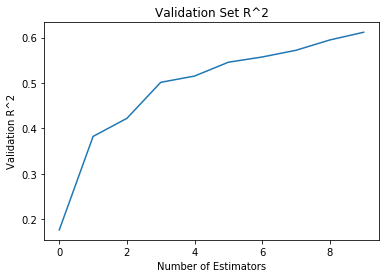

In [338]:
tree_predictor(10)

The Weighted F1 Score is: 0.9421985738745963
The Precision Score is: 0.9458751680973904
The Recall Score is: 0.9459459459459459


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.95      0.99      0.97       283
      Churn       0.94      0.68      0.79        50

avg / total       0.95      0.95      0.94       333



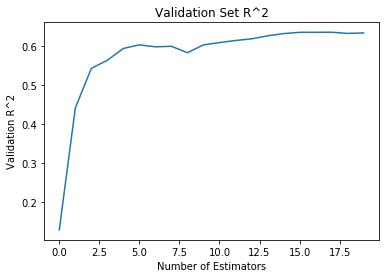

In [339]:
tree_predictor(20)

The Weighted F1 Score is: 0.9486209545551969
The Precision Score is: 0.9529074529074529
The Recall Score is: 0.9519519519519519


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.95      1.00      0.97       283
      Churn       0.97      0.70      0.81        50

avg / total       0.95      0.95      0.95       333



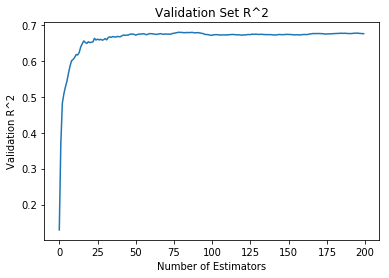

In [340]:
tree_predictor(200)

## Parameter Setting with OOB Scores

In [341]:
RANDOM_STATE=2019

In [342]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

In [343]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [344]:
min_estimators = 15
max_estimators = 200

In [345]:
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(train, labels)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

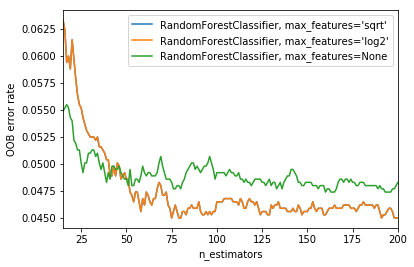

In [346]:
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### Overfitting

Baseline

In [347]:
m = RandomForestClassifier(n_estimators=100,oob_score=True,n_jobs=-1,max_features='log2')
m.fit(X_train,y_train)
print("OOB Score is: {}".format(m.oob_score_))
print_score(m)

OOB Score is: 0.9516666666666667
The Weighted F1 Score is: 0.9415409518502302
The Precision Score is: 0.9472645968809653
The Recall Score is: 0.9459459459459459


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.94      1.00      0.97       283
      Churn       0.97      0.66      0.79        50

avg / total       0.95      0.95      0.94       333



#### Min_samples_leaf

In [348]:
m = RandomForestClassifier(n_estimators=100,min_samples_leaf=3,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print("OOB Score is: {}".format(m.oob_score_))
print_score(m)

OOB Score is: 0.953
The Weighted F1 Score is: 0.9451034511275476
The Precision Score is: 0.9500804735704064
The Recall Score is: 0.948948948948949


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.95      1.00      0.97       283
      Churn       0.97      0.68      0.80        50

avg / total       0.95      0.95      0.95       333



Similar performance

## Feature Importance

In [349]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [350]:
m = RandomForestClassifier(n_estimators=100,oob_score=True,min_samples_leaf=3, n_jobs=-1,max_features='log2')
m.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [351]:
importances = m.feature_importances_

In [352]:
std = np.std([tree.feature_importances_ for tree in m.estimators_], axis=0)

In [353]:
indices = np.argsort(importances)[::-1]

In [354]:
indices

array([ 5, 15,  3,  8,  6, 13, 16, 17, 12, 14,  9, 11,  0,  4,  2, 10,  7, 18, 19,  1])

In [355]:
indices_labelled = []
for i in indices:
    indices_labelled.append(X_train.columns[i])

In [356]:
indices_labelled

['Total day charge',
 'Customer service calls',
 'Total day minutes',
 'Total eve charge',
 'Total eve minutes',
 'Total intl calls',
 'International plan_No',
 'International plan_Yes',
 'Total intl minutes',
 'Total intl charge',
 'Total night minutes',
 'Total night charge',
 'Account length',
 'Total day calls',
 'Number vmail messages',
 'Total night calls',
 'Total eve calls',
 'Voice mail plan_No',
 'Voice mail plan_Yes',
 'Area code']

In [357]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], indices_labelled[f], importances[indices[f]]))

Feature ranking:
1. feature 5 - Total day charge (0.150917)
2. feature 15 - Customer service calls (0.141613)
3. feature 3 - Total day minutes (0.128560)
4. feature 8 - Total eve charge (0.062220)
5. feature 6 - Total eve minutes (0.059544)
6. feature 13 - Total intl calls (0.055581)
7. feature 16 - International plan_No (0.050730)
8. feature 17 - International plan_Yes (0.050392)
9. feature 12 - Total intl minutes (0.045000)
10. feature 14 - Total intl charge (0.043719)
11. feature 9 - Total night minutes (0.033705)
12. feature 11 - Total night charge (0.031431)
13. feature 0 - Account length (0.023537)
14. feature 4 - Total day calls (0.023360)
15. feature 2 - Number vmail messages (0.021978)
16. feature 10 - Total night calls (0.020967)
17. feature 7 - Total eve calls (0.020197)
18. feature 18 - Voice mail plan_No (0.015877)
19. feature 19 - Voice mail plan_Yes (0.015064)
20. feature 1 - Area code (0.005607)


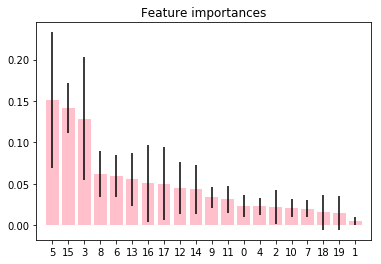

In [358]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="pink", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## AUC

In [359]:
from sklearn.metrics import roc_curve, roc_auc_score

In [360]:
pred_prob = m.predict_proba(X_valid)
prob_churn = [p[1] for p in pred_prob]
auc = roc_auc_score(y_valid, prob_churn)

In [361]:
print("AUC Score is {}".format(auc))

AUC Score is 0.9299999999999999


## Tree Interpreter

In [362]:
from treeinterpreter import treeinterpreter as ti

In [363]:
row = X_valid.values[None,1]; row

array([[ 71.  , 415.  ,  39.  , 183.2 , 103.  ,  31.14, 209.4 , 111.  ,  17.8 , 172.4 , 109.  ,   7.76,  11.9 ,
          6.  ,   3.21,   1.  ,   1.  ,   0.  ,   0.  ,   1.  ]])

In [364]:
prediction, bias, contributions = ti.predict(m, row)

In [365]:
prediction[0], bias[0]

(array([0.950786, 0.049214]), array([0.85662, 0.14338]))

In [366]:
contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]

In [367]:
colnames = train.columns[0:].values

### Waterfall

In [368]:
import waterfall_chart

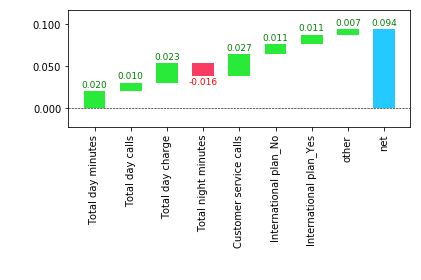

In [369]:
my_plot=waterfall_chart.plot(colnames,contributions, rotation_value=90, threshold=0.3,formatting='{:,.3f}')

# Parameter Grid Search

https://github.com/chrispaulca/waterfall/blob/master/Tree_interpreter_Example.ipynb

In [375]:
baseRF = RandomForestClassifier(n_estimators = 100, 
                               random_state = 0,
                               n_jobs = -1,
                               oob_score = True)

In [378]:
param_grid = {
    'min_samples_leaf' :[1,3,5], 
    'max_features' : [None, 'log2', 'sqrt', 3],
    'criterion' : ['gini','entropy']
}

In [379]:
from sklearn.model_selection import GridSearchCV
cvRF = GridSearchCV(estimator=baseRF, param_grid=param_grid, cv=3, scoring='roc_auc')
cvRF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 3, 5], 'max_features': [None, 'log2', 'sqrt', 3], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [380]:
cvRF.best_params_

{'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 1}

In [381]:
cvRF.best_score_

0.9169589577447844

Worse than the hand-fit model

In [382]:
model = RandomForestClassifier(n_estimators = 100, 
                               random_state = 0,
                               n_jobs = -1,
                               oob_score = True,
                               criterion = 'entropy',
                               min_samples_leaf = 1)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [383]:
model.oob_score_

0.9516666666666667

In [384]:
print_score(model)

The Weighted F1 Score is: 0.9555278776732065
The Precision Score is: 0.9585976699268403
The Recall Score is: 0.9579579579579579


                       Test Set Results
             precision    recall  f1-score   support

   No Churn       0.96      1.00      0.98       283
      Churn       0.97      0.74      0.84        50

avg / total       0.96      0.96      0.96       333



## Interpreter

In [387]:
importances = model.feature_importances_

In [388]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

In [389]:
indices = np.argsort(importances)[::-1]

In [390]:
indices

array([ 3, 15,  5,  6,  8, 13, 17, 14, 12, 16, 11,  9,  0,  4,  7, 10,  2, 19, 18,  1])

In [391]:
indices_labelled = []
for i in indices:
    indices_labelled.append(X_train.columns[i])

In [392]:
indices_labelled

['Total day minutes',
 'Customer service calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve charge',
 'Total intl calls',
 'International plan_Yes',
 'Total intl charge',
 'Total intl minutes',
 'International plan_No',
 'Total night charge',
 'Total night minutes',
 'Account length',
 'Total day calls',
 'Total eve calls',
 'Total night calls',
 'Number vmail messages',
 'Voice mail plan_Yes',
 'Voice mail plan_No',
 'Area code']

In [393]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], indices_labelled[f], importances[indices[f]]))

Feature ranking:
1. feature 3 - Total day minutes (0.126997)
2. feature 15 - Customer service calls (0.126116)
3. feature 5 - Total day charge (0.116373)
4. feature 6 - Total eve minutes (0.066111)
5. feature 8 - Total eve charge (0.064509)
6. feature 13 - Total intl calls (0.052564)
7. feature 17 - International plan_Yes (0.048293)
8. feature 14 - Total intl charge (0.046830)
9. feature 12 - Total intl minutes (0.045272)
10. feature 16 - International plan_No (0.043584)
11. feature 11 - Total night charge (0.042568)
12. feature 9 - Total night minutes (0.041848)
13. feature 0 - Account length (0.033008)
14. feature 4 - Total day calls (0.030712)
15. feature 7 - Total eve calls (0.030393)
16. feature 10 - Total night calls (0.030295)
17. feature 2 - Number vmail messages (0.019572)
18. feature 19 - Voice mail plan_Yes (0.014586)
19. feature 18 - Voice mail plan_No (0.011747)
20. feature 1 - Area code (0.008621)


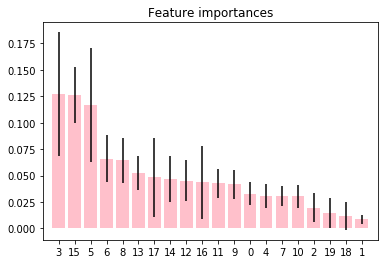

In [394]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="pink", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## AUC

In [395]:
pred_prob = model.predict_proba(X_valid)
prob_churn = [p[1] for p in pred_prob]
auc = roc_auc_score(y_valid, prob_churn)

In [396]:
print("AUC Score is {}".format(auc))

AUC Score is 0.9229328621908127


## Waterfall

In [385]:
prediction, bias, contributions = ti.predict(model, row)

prediction[0], bias[0]

contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]

colnames = train.columns[0:].values

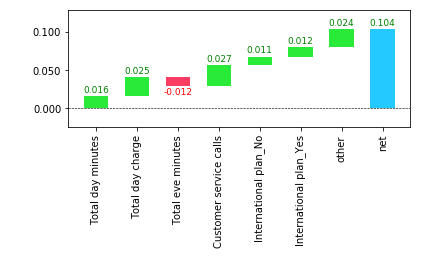

In [386]:
my_plot=waterfall_chart.plot(colnames,contributions, rotation_value=90, threshold=0.3,formatting='{:,.3f}')